![alt text][logo]

[logo]: https://github.com/legolason/PyQSOFit/blob/master/QSOFit_logo.png?raw=true


# PyQSOFit


PyQSOFit is a flexible tool to decompose the quasar spectrum. It‘s transferred from [Yue Shen](http://quasar.astro.illinois.edu/)'s IDL qsofit code, but not exactly the same. With this program, people can get the information of quasar continuum and emission lines, e.g., continuum slope, line FWHM, line dispersion, EW, peak, etc. The main flows of this code are:

1) We decompose the host galaxy and quasar component with the PCA method if needed

2) We fit the continuum with several components (Power-Law, Polynomial, Fe II, Balmer Continuum) using some line free windows

3) We fit line complexes one by one, including H$\alpha$, H$\beta$, Mg II, C III], CIV and Ly$\alpha$ complex. In each complex, broad and narrow Gaussian profiles are used to fit different emission lines. 

For the details, you can read [Shen et al. (2015)](http://adsabs.harvard.edu/abs/2018arXiv181001447S), [Guo et al. (2018)](http://adsabs.harvard.edu/abs/2018arXiv180904610G) and Wang et al.(2018, in prepration)


## Installation and Requirements
To install this code, just copy the whole package to your directory. This code was tested on Python 2.7 and Python 3.6. Some packages are required:

1) [Numpy](http://www.numpy.org/)<br>
2) [Scipy](https://www.scipy.org/)<br>
3) [Astropy](http://www.astropy.org/)<br>
4) [PyAstronomy](https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/index.html)<br>
5) [Kmpfit](https://www.astro.rug.nl/software/kapteyn/kmpfittutorial.html)<br>
6) [Sfdmap](https://github.com/kbarbary/sfdmap): dust reddening map from [Schlegel et al. (2008)](http://www.adsabs.harvard.edu/abs/1998ApJ...500..525S), which can be downloaded [here](https://github.com/kbarbary/sfddata)<br>
7) Eigenspectra of galaxy and quasar from Yip et al. [(2004a)](http://adsabs.harvard.edu/abs/2004AJ....128..585Y), [(2004b)](http://adsabs.harvard.edu/abs/2004AJ....128.2603Y)<br>
8) Optical/UV Fe II templete (already included in this package).

We suggest that install python through [anaconda](https://www.anaconda.com/), which incorporates most packages you need.  

## Key features
1) Fit the whole spectra input or fit each line locally using "wave_range" parameter

2) Monte Carlo error is available for each parameter. We note that the error coming from KMPFIT is not trustable, so we did not output the KMPFIT errors as default results. But user still can read out this errors through KMPFIT.params. The better way to calculate the error is using the Monte Carlo method, which perturbs the flux based on the input error. However, this will take a longer time to do the calculation.

3) A 3rd order polynomial component accounts for dust reddening if any.

4) Iterative sigma clipping can be used to clean the spectrum for absorbed continuum fitting. 

5) One can block serval ranges on the spectrum for bad S/N ratio pixels or absorption lines.

6) The code directly saves out the properties of emission lines, e.g., FWHM, line dispersion, EW, Peak, line flux for the broad components and continuum luminosity at 1350, 3000, 5100A.

7) One can remove the bad pixels caused by the cosmic ray or the sky. 



## Possible future updates
1) Use Gauss-Hermite profile to fit the emission lines.<br>
2) Simultaneously fit several epochs for the same source since the time domain era is coming.<br>
3) Add functions to fit the absorption lines.<br>
4) Produce more secondary parameters from spectral fitting.<br>
5) Speed up the code.<br> 


## Disadvantages
1) Speed problem. Comparing to the IDL version, the speed bottleneck is the core function Kmpfit based on Cython. For each source, it takes about 3 ~ 20s. If add the MC method to calculate the error, it will take about 5 to 10 Min for each source. Excluding the polynomial component or choosing proper initial parameters will alleviate this problem. 

2) We can only tie TWO pairs of doublets (four lines) to certain values, such as tieing [SII] doublets and [NII] doublets together in H$\alpha$ complex fitting. We cannot tie a range or more lines so far.

3) For very low S/N ratio spectral and BAL quasar, the performance is not good. Try to exclude them before fitting if a larger sample is used.

## Authors
[Hengxiao Guo](https://hengxiaoguo.wixsite.com/hengxiaoguo), hengxiaoguo AT gmail.com (UIUC)<br>
[Yue Shen](http://quasar.astro.illinois.edu/), shenyue AT illinois.edu (UIUC)<br>
Shu Wang, wangshukiaa AT pku.edu.cn (Peking University)


## Acknowledgement
If our code makes your life easier, it would be appreciated to cite us:<br>
1) [Guo, H., Liu, X., Shen, Y., et al. 2018, arXiv:1809.04610](http://adsabs.harvard.edu/abs/2018arXiv180904610G)<br>
2) [Shen, Y., Hall, P.~B., Horne, K., et al.\ 2018, arXiv:1810.01447](http://adsabs.harvard.edu/abs/2018arXiv181001447S)

<br>
<br>
<br>





## Detailed Usage

## 1. Fit type 1 QSO

__Step 1__:<br>
Firstly, run the script below to produce the line list file, qsopar.fits, containing lines and their constraints, which will be needed in the following fitting program. From this file, you can change some specific parameters to suit your requirements, e.g., fitting range, line width, tie line center, tie line sigma, etc. If you want to fit extra lines, please append it to corresponding complex. Note that our line wavelength and sigma in the list are in Ln scale, like Lnlambda, Lnsigma. 

In [40]:
%matplotlib inline
import glob, os,sys,timeit
import matplotlib
import numpy as np
sys.path.append('../')
from PyQSOFit import QSOFit
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

path='../'

newdata = np.rec.array([(6564.61,'Ha',6400.,6800.,'Ha_br',3,5e-3,0.004,0.05,0.015,0,0,0,0.05),\
                        (6564.61,'Ha',6400.,6800.,'Ha_na',1,1e-3,5e-4,0.0017,0.01,1,1,0,0.002),\
                        (6549.85,'Ha',6400.,6800.,'NII6549',1,1e-3,2.3e-4,0.0017,5e-3,1,1,1,0.001),\
                        (6585.28,'Ha',6400.,6800.,'NII6585',1,1e-3,2.3e-4,0.0017,5e-3,1,1,1,0.003),\
                        (6718.29,'Ha',6400.,6800.,'SII6718',1,1e-3,2.3e-4,0.0017,5e-3,1,1,2,0.001),\
                        (6732.67,'Ha',6400.,6800.,'SII6732',1,1e-3,2.3e-4,0.0017,5e-3,1,1,2,0.001),\
                        
                        (4862.68,'Hb',4640.,5100.,'Hb_br',1,5e-3,0.004,0.05,0.01,0,0,0,0.01),\
                        (4862.68,'Hb',4640.,5100.,'Hb_na',1,1e-3,2.3e-4,0.0017,0.01,1,1,0,0.002),\
                        (4960.30,'Hb',4640.,5100.,'OIII4959c',1,1e-3,2.3e-4,0.0017,0.01,1,1,0,0.002),\
                        (5008.24,'Hb',4640.,5100.,'OIII5007c',1,1e-3,2.3e-4,0.0017,0.01,1,1,0,0.004),\
                        #(4960.30,'Hb',4640.,5100.,'OIII4959w',1,3e-3,2.3e-4,0.004,0.01,2,2,0,0.001),\
                        #(5008.24,'Hb',4640.,5100.,'OIII5007w',1,3e-3,2.3e-4,0.004,0.01,2,2,0,0.002),\
                        #(4687.02,'Hb',4640.,5100.,'HeII4687_br',1,5e-3,0.004,0.05,0.005,0,0,0,0.001),\
                        #(4687.02,'Hb',4640.,5100.,'HeII4687_na',1,1e-3,2.3e-4,0.0017,0.005,1,1,0,0.001),\
                        
                        #(3934.78,'CaII',3900.,3960.,'CaII3934',2,1e-3,3.333e-4,0.0017,0.01,99,0,0,-0.001),\
                        
                        #(3728.48,'OII',3650.,3800.,'OII3728',1,1e-3,3.333e-4,0.0017,0.01,1,1,0,0.001),\
                        
                        #(3426.84,'NeV',3380.,3480.,'NeV3426',1,1e-3,3.333e-4,0.0017,0.01,0,0,0,0.001),\
                        #(3426.84,'NeV',3380.,3480.,'NeV3426_br',1,5e-3,0.0025,0.02,0.01,0,0,0,0.001),\
                        
                        (2798.75,'MgII',2700.,2900.,'MgII_br',3,5e-3,0.004,0.05,0.0017,0,0,0,0.05),\
                        (2798.75,'MgII',2700.,2900.,'MgII_na',3,1e-3,5e-4,0.0017,0.01,1,1,0,0.002),\
                        
                        
                        (1908.73,'CIII',1700.,1970.,'CIII_br',2,5e-3,0.004,0.05,0.015,99,0,0,0.01),\
                        #(1908.73,'CIII',1700.,1970.,'CIII_na',1,1e-3,5e-4,0.0017,0.01,1,1,0,0.002),\
                        #(1892.03,'CIII',1700.,1970.,'SiIII1892',1,2e-3,0.001,0.015,0.003,1,1,0,0.005),\
                        #(1857.40,'CIII',1700.,1970.,'AlIII1857',1,2e-3,0.001,0.015,0.003,1,1,0,0.005),\
                        #(1816.98,'CIII',1700.,1970.,'SiII1816',1,2e-3,0.001,0.015,0.01,1,1,0,0.0002),\
                        #(1786.7,'CIII',1700.,1970.,'FeII1787',1,2e-3,0.001,0.015,0.01,1,1,0,0.0002),\
                        #(1750.26,'CIII',1700.,1970.,'NIII1750',1,2e-3,0.001,0.015,0.01,1,1,0,0.001),\
                        #(1718.55,'CIII',1700.,1900.,'NIV1718',1,2e-3,0.001,0.015,0.01,1,1,0,0.001),\
                        
                        (1549.06,'CIV',1500.,1700.,'CIV_br',1,5e-3,0.004,0.05,0.015,0,0,0,0.05),\
                        (1549.06,'CIV',1500.,1700.,'CIV_na',1,1e-3,5e-4,0.0017,0.01,1,1,0,0.002),\
                        #(1640.42,'CIV',1500.,1700.,'HeII1640',1,1e-3,5e-4,0.0017,0.008,1,1,0,0.002),\
                        #(1663.48,'CIV',1500.,1700.,'OIII1663',1,1e-3,5e-4,0.0017,0.008,1,1,0,0.002),\
                        #(1640.42,'CIV',1500.,1700.,'HeII1640_br',1,5e-3,0.0025,0.02,0.008,1,1,0,0.002),\
                        #(1663.48,'CIV',1500.,1700.,'OIII1663_br',1,5e-3,0.0025,0.02,0.008,1,1,0,0.002),\
                        
                        #(1402.06,'SiIV',1290.,1450.,'SiIV_OIV1',1,5e-3,0.002,0.05,0.015,1,1,0,0.05),\
                        #(1396.76,'SiIV',1290.,1450.,'SiIV_OIV2',1,5e-3,0.002,0.05,0.015,1,1,0,0.05),\
                        #(1335.30,'SiIV',1290.,1450.,'CII1335',1,2e-3,0.001,0.015,0.01,1,1,0,0.001),\
                        #(1304.35,'SiIV',1290.,1450.,'OI1304',1,2e-3,0.001,0.015,0.01,1,1,0,0.001),\
                        
                        (1215.67,'Lya',1150.,1290.,'Lya_br',1,5e-3,0.004,0.05,0.02,0,0,0,0.05),\
                        (1215.67,'Lya',1150.,1290.,'Lya_na',1,1e-3,5e-4,0.0017,0.01,0,0,0,0.002)\
                        ],\
                     formats='float32,a20,float32,float32,a20,float32,float32,float32,float32,\
                     float32,float32,float32,float32,float32',\
                     names='lambda,compname,minwav,maxwav,linename,ngauss,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue')
#------header-----------------
hdr = fits.Header()
hdr['lambda'] = 'Vacuum Wavelength in Ang'
hdr['minwav'] = 'Lower complex fitting wavelength range'
hdr['maxwav'] = 'Upper complex fitting wavelength range'
hdr['ngauss'] = 'Number of Gaussians for the line'
hdr['inisig'] = 'Initial guess of linesigma [in lnlambda]'
hdr['minsig'] = 'Lower range of line sigma [lnlambda]'  
hdr['maxsig'] = 'Upper range of line sigma [lnlambda]'
hdr['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr['fvalue'] = 'Relative scale factor for entries w/ same findex'
#------save line info-----------
hdu = fits.BinTableHDU(data=newdata,header=hdr,name='data')
hdu.writeto(path+'qsopar.fits',overwrite=True)


__Step 2__:<br>
Setup the paths and read in your spectrum. Our code is written under the frame of SDSS spectral data format. Other data is also available as long as they include wavelength, flux, error, and redshift, and make sure the wavelength resolution is the same as SDSS spectrum (For SDSS the pixel scale is 1.e-4 in log space).

In [41]:
data=fits.open('../example/data/J1554+1937_sdssrebin.fits')

In [42]:
data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   40 / length of dimension 1                          
NAXIS2  =                 6953 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'Rest-frame Wavelength'                                               
TFORM1  = 'D       '                                                            
TTYPE2  = 'Flux    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Flux Errors'     

In [43]:

path1='../'                  # the path of the source code file and qsopar.fits
path2='./data/result/' # path of fitting results
path3='./data/QA_other/'   # path of figure
path4='../sfddata/'             # path of dusp reddening map

#Requried
# an important note that all the data input must be finite, especically for the error !!!
data = fits.open(path1+'example/data/J1554+1937_sdssrebin.fits')
mask = data[1].data["Mask"]
z    = data[1].data['Redshift'][0]                # Redshift
lam  = data[1].data['Rest-frame Wavelength']*(1+z)        # OBS wavelength [A]
flux = data[1].data['Flux']             # OBS flux [erg/s/cm^2/A]
err  = data[1].data['Flux Errors']  # 1 sigma error
err[mask!=0] = 0.
flux[mask!=0] = 0.

#Optinal
"""
ra=data[0].header['plug_ra']          # RA 
dec=data[0].header['plug_dec']        # DEC
plateid = data[0].header['plateid']   # SDSS plate ID
mjd = data[0].header['mjd']           # SDSS MJD
fiberid = data[0].header['fiberid']   # SDSS fiber ID
"""


"\nra=data[0].header['plug_ra']          # RA \ndec=data[0].header['plug_dec']        # DEC\nplateid = data[0].header['plateid']   # SDSS plate ID\nmjd = data[0].header['mjd']           # SDSS MJD\nfiberid = data[0].header['fiberid']   # SDSS fiber ID\n"

__Step 3__:<br>
Use QSOFit to input the lam, flux, err, z, and other optinal parameters. Use function Fit to perform the fitting. Default settings cannot meet all needs. Please change settings for your own requirements. It depends on what science you need. The following example set dereddening, host decomposition to True and do not perform error measurement using Monte Carlo method.

In [44]:
np.isnan(err).sum()

0

[1 1]
[2]
[3 3]
Fitting finished in : 2.0s


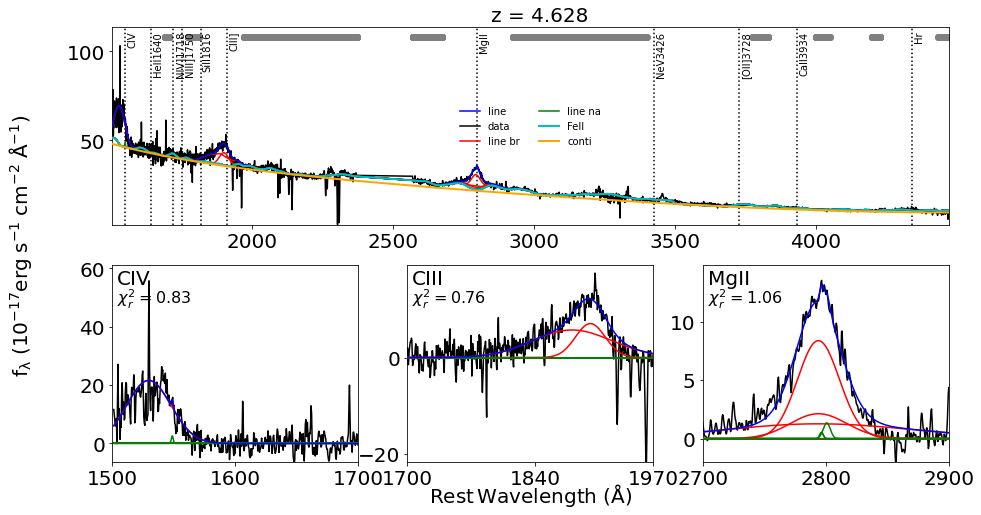

In [45]:
# get data prepared 
q = QSOFit(lam, flux*10**17, err*10**17, z, path = path1, or_mask=mask)

start = timeit.default_timer()
# do the fitting
q.Fit(name = None,nsmooth = 1, and_or_mask = False, deredden = True, reject_badpix = False, wave_range = None,\
      wave_mask =None, decomposition_host = False, Mi = None, npca_gal = 5, npca_qso = 20, \
      Fe_uv_op = True, Fe_flux_range=np.array([2000,4435]), poly = True, BC = False, rej_abs = False, \
      initial_guess = None, MC = False, n_trails = 5, linefit = True, tie_lambda = True, tie_width = True, \
      tie_flux_1 = True, tie_flux_2 = True, save_result = True, plot_fig = True,save_fig = False, \
      plot_line_name = True, plot_legend = True, dustmap_path = path4, save_fig_path = path3, \
      save_fits_path = path2,save_fits_name = None)

end = timeit.default_timer()

print('Fitting finished in : '+str(np.round(end-start))+'s')
    
# grey shade on the top is the continuum windiows used to fit.

By now, you already finish the QSO fitting part. 

### Step 4:
#### Get all models for the whole spectrum

Continue to look at this section and below if you want to do some further calculations based on the fitting results. Here, we show how to extract different models from our fitting results, such as continuum model, emission line models and host galaxy component. Note that the emission regions of host galaxy template should be blocked, e.g., H$\alpha$ [6540, 6590].

There are two ways to calculate the $Fe_{II}$ flux within given ranges:
1. If you want the program calculate the $Fe_{II}$ flux automatically and documented them in result file, you can use the parameter `Fe_flux_range` in `Fit()` to assign ranges.
2. We also provide build-in function `Get_Fe_flux` to calculate the $Fe_{II}$ flux directly after you finished the fitting part.

Fe flux within a specific range: 
Fe_flux_4400_4900: 0.0


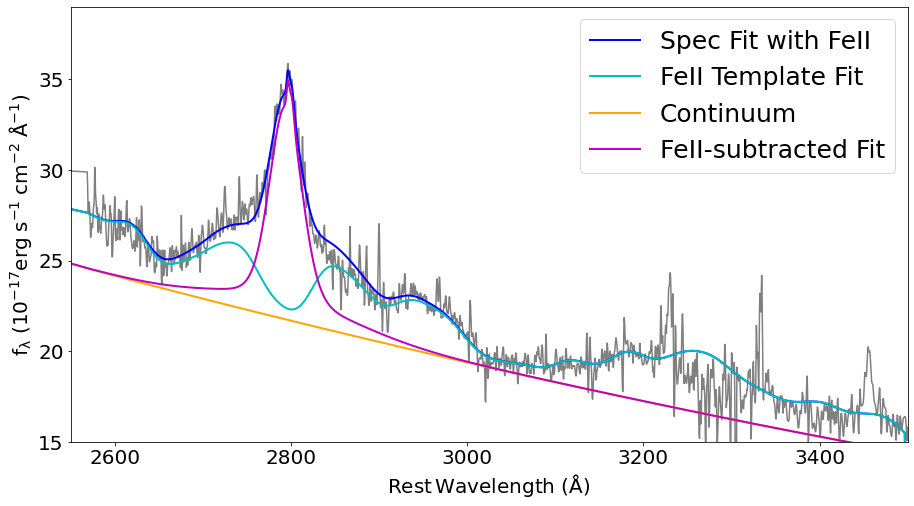

In [58]:
fig=plt.figure(figsize=(15,8))
#plot the quasar rest frame spectrum after removed the host galaxy component
plt.plot(q.wave,q.flux,'grey')              
plt.plot(q.wave,q.err,'r')


#To plot the whole model, we use Manygauss to reappear the line fitting results saved in gauss_result  
plt.plot(q.wave,q.Manygauss(np.log(q.wave),q.gauss_result)+q.f_conti_model,'b',label='Spec Fit with FeII',lw=2)
plt.plot(q.wave,q.f_conti_model,'c',lw=2, label="FeII Template Fit")
plt.plot(q.wave,q.PL_poly_BC,"orange",label='Continuum',lw=2)
plt.plot(q.wave,q.Manygauss(np.log(q.wave),q.gauss_result)+q.PL_poly_BC,'m',label='FeII-subtracted Fit',lw=2)
#plt.plot(q.wave,q.host,'m',lw=2)

plt.xlim(2550,3500)
plt.ylim(15,39)
plt.xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize = 20)
plt.ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize = 20)
plt.legend(loc="upper right", prop={"size":25})

#print('optical Fe flux (10^(-17) erg/s/cm^2): '+q.conti_result[q.conti_result_name=='Fe_flux_4435_4685'][0])

Fe_flux_result,Fe_flux_type,Fe_flux_name = q.Get_Fe_flux(np.array([4400,4900]))
print('Fe flux within a specific range: \n'+Fe_flux_name[0]+': '+str(Fe_flux_result[0]))

### Setp 5:
#### Get models for each line complex
All the line parameters are in the gauss_result, it was saved following the order of qsopar.fits. For each Gaussian, three parameter (scale, Ln(lambda), Ln(sigma)) are saved.
If you want to filter the line below or above 1200 km/s (lnsigma = 0.0017), the function CalFWHM can be used as following.
The line_prop is desiged to calculate the broad line properties, not for the narrow line.

Broad MgII:
FWHM (km/s) 4537.5
Sigma (km/s) 1901.3
EW (A) 20.7
Peak (A) 1529.7
area (10^(-17) erg/s/cm^2) 971.2


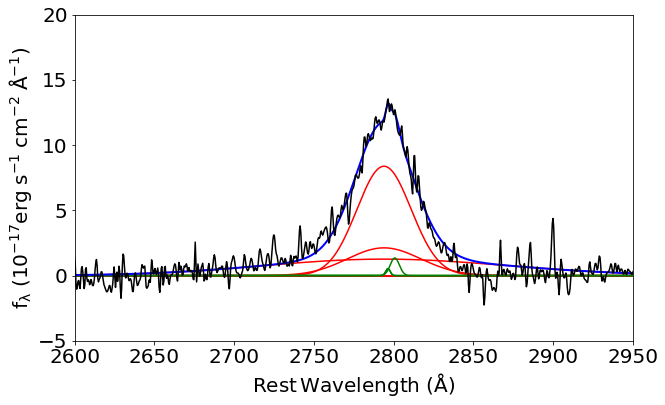

In [57]:
fig=plt.figure(figsize=(10,6))
for p in range(int(len(q.gauss_result)/3)):
    if q.CalFWHM(q.gauss_result[3*p+2] ) < 1200.:  # < 1200 km/s narrow
        color = 'g'
    else:
        color = 'r'
    plt.plot(q.wave,q.Onegauss(np.log(q.wave),q.gauss_result[p*3:(p+1)*3]),color=color)
plt.plot(q.wave,q.Manygauss(np.log(q.wave),q.gauss_result),'b',lw=2)
plt.plot(q.wave,q.line_flux,'k')
plt.xlim(2600,2950)
plt.ylim(-5,20)
plt.xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize = 20)
plt.ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize = 20)




# the line_prop function is used to calculate the broad line properties (Lnsigma > 0.0017 (1200 km/s) )
#print q.line_result_name
#if you want to calculate the paramters of broad Hb
#then find all the broad Hb component, i.e., Hb_br_[1,2,3]_[scale,centerwave,sigma]
#for here q.line_result_name[12:15],q.line_result[12:15] is the broad Hb

fwhm,sigma,ew,peak,area = q.line_prop(q.linelist[10][0],q.line_result[18:21],'broad') 
print("Broad MgII:")
print("FWHM (km/s)", np.round(fwhm,1))
print("Sigma (km/s)", np.round(sigma,1))
print("EW (A)",np.round(ew,1))
print("Peak (A)",np.round(peak,1))
print("area (10^(-17) erg/s/cm^2)",np.round(area,1))

In [9]:
q.gauss_result

array([6.36509826e-01, 7.33294719e+00, 1.17575479e-02, 3.28137766e-03,
       7.34539624e+00, 5.00000024e-04, 1.50892626e-01, 7.54997224e+00,
       8.57418138e-03, 3.34015878e-01, 7.53919363e+00, 2.33934201e-02,
       2.09162524e-01, 7.93522835e+00, 8.21611990e-03, 1.30142986e-02,
       7.93651692e+00, 1.70000002e-03, 0.00000000e+00, 7.93692827e+00,
       1.00000005e-03])

In [64]:
q.linelist[10], q.linelist

((2798.75, 'MgII', 2700.0, 2900.0, 'MgII_br', 1.0, 0.005, 0.004, 0.05, 0.0017, 0.0, 0.0, 0.0, 0.05),
 FITS_rec([(6564.61, 'Ha', 6400., 6800., 'Ha_br', 3., 0.005, 0.004  , 0.05  , 0.015 ,  0., 0., 0., 0.05 ),
           (6564.61, 'Ha', 6400., 6800., 'Ha_na', 1., 0.001, 0.0005 , 0.0017, 0.01  ,  1., 1., 0., 0.002),
           (6549.85, 'Ha', 6400., 6800., 'NII6549', 1., 0.001, 0.00023, 0.0017, 0.005 ,  1., 1., 1., 0.001),
           (6585.28, 'Ha', 6400., 6800., 'NII6585', 1., 0.001, 0.00023, 0.0017, 0.005 ,  1., 1., 1., 0.003),
           (6718.29, 'Ha', 6400., 6800., 'SII6718', 1., 0.001, 0.00023, 0.0017, 0.005 ,  1., 1., 2., 0.001),
           (6732.67, 'Ha', 6400., 6800., 'SII6732', 1., 0.001, 0.00023, 0.0017, 0.005 ,  1., 1., 2., 0.001),
           (4862.68, 'Hb', 4640., 5100., 'Hb_br', 1., 0.005, 0.004  , 0.05  , 0.01  ,  0., 0., 0., 0.01 ),
           (4862.68, 'Hb', 4640., 5100., 'Hb_na', 1., 0.001, 0.00023, 0.0017, 0.01  ,  1., 1., 0., 0.002),
           (4960.3 , 'Hb', 4640., 5

In [71]:
q.line_result[18:21]

array(['0.6365098259334973', '7.332947194126176', '0.011757547924029471'],
      dtype='<U32')

In [69]:
q.line_result

array(['CIV', '1', '347.4442307211732', '0.8331995940555712', '32', '417',
       'CIII', '1', '439.3612623565244', '0.7562155978597666', '28',
       '581', 'MgII', '2', '683.891185656112', '1.5333883086459912', '20',
       '446', '0.6365098259334973', '7.332947194126176',
       '0.011757547924029471', '0.0032813776560769933',
       '7.345396235900966', '0.0005000000237487257', '0.1508926263085431',
       '7.549972240295024', '0.00857418137875277', '0.3340158777569654',
       '7.539193630218506', '0.02339342005511846', '0.2091625236598296',
       '7.93522834777832', '0.008216119899493793', '0.013014298587695398',
       '7.936516923088867', '0.0017000000225380063', '0.0',
       '7.9369282722473145', '0.0010000000474974513', '8198.123522250195',
       '3435.1839113924007', '20.703562793018794', '1529.7070815859977',
       '971.221685515412', '9100.824381235017', '5992.980399382013',
       '25.38409820495949', '1898.6332936997815', '913.3361952611751',
       '4608.42047876311

### Step 6:
### Multiprocessing
Since our code is not faster as IDL version and to calculate the MC-based uncertainties will cost a lot of time, we always use the multiprocessing method to speed up the large sample fitting. 

We note that running multiprocessing on jupyter notebook may lead to various errors depending on the environment. The example here is only tested in MacOS Big Sur 11.2 with python 3.8.5. Running multiprocessing in non-interactive interpreters is recommended. For more informations: https://docs.python.org/3/library/multiprocessing.html

Besides, for the convenience of display, the code wouldn't close the figure automatically which could lead to memory leak by child process if one uses multiprocessing. Considering the common memory size of modern computer is relatively large, dealing with a small amount of spectrum (say, less than 100) at a time is acceptable and those occupied memory would be released once the main process ends. However, if one needs to handle more spectrum, one can add `plt.close()` at the end of the function `QSOFit._PlotFig` in `PyQSOFit.py` or at the child process after spectrum are fitted (`import matplotlib.pyplot as plt` is also needed).

In [6]:
%%writefile temp_job.py

import sys
import numpy as np
sys.path.append('../')
from PyQSOFit import QSOFit
from astropy.io import fits


path1 = '../'  # the path of the source code file and qsopar.fits
path2 = './data/result/'  # path of fitting results
path3 = './data/QA_other/'  # path of figure
path4 = '../sfddata/'  # path of dusp reddening map



def job(files):
    data = fits.open(files)
    
    lam = 10**data[1].data['loglam']
    flux = data[1].data['flux']
    err = 1./np.sqrt(data[1].data['ivar'])
    ra = data[0].header['plug_ra']
    dec = data[0].header['plug_dec']
    z = data[2].data['z'][0]
    plateid = data[0].header['plateid']
    mjd = data[0].header['mjd']
    fiberid = data[0].header['fiberid']
    
    q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path1)

    q.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, wave_mask=None,
          decomposition_host=True, Mi=None, npca_gal=5, npca_qso=20, Fe_uv_op=True, poly=True, BC=False, rej_abs=False,
          initial_guess=None, MC=False, n_trails=5, linefit=True, tie_lambda=True, tie_width=True, tie_flux_1=False,
          tie_flux_2=False, save_result=False, plot_fig=True, save_fig=True, plot_line_name=True, plot_legend=True,
          dustmap_path=path4, save_fig_path=path3, save_fits_path=path2, save_fits_name=None)

Overwriting temp_job.py


In [7]:
# Edit the directory before use. 

from multiprocessing import Pool
from temp_job import job

if __name__ == '__main__':
    start = timeit.default_timer()
    
    files = []
    for path in zip(glob.glob(path1+'example/data/*.fits')):
        files.append(path[0])
    
    pool = Pool()                         # Create a multiprocessing Pool
    pool.map(job, files)
    
    end = timeit.default_timer()
    print('Fitting finished in : '+str(np.round(end-start))+'s')

os.remove('temp_job.py')

Fitting finished in : 14.0s


### 2. Fit emission line galaxy
This code can also fit some narrow line object, e.g.,emission line galaxy, Narrow-line Seyfert 1 (NLS1) galaxies, etc.

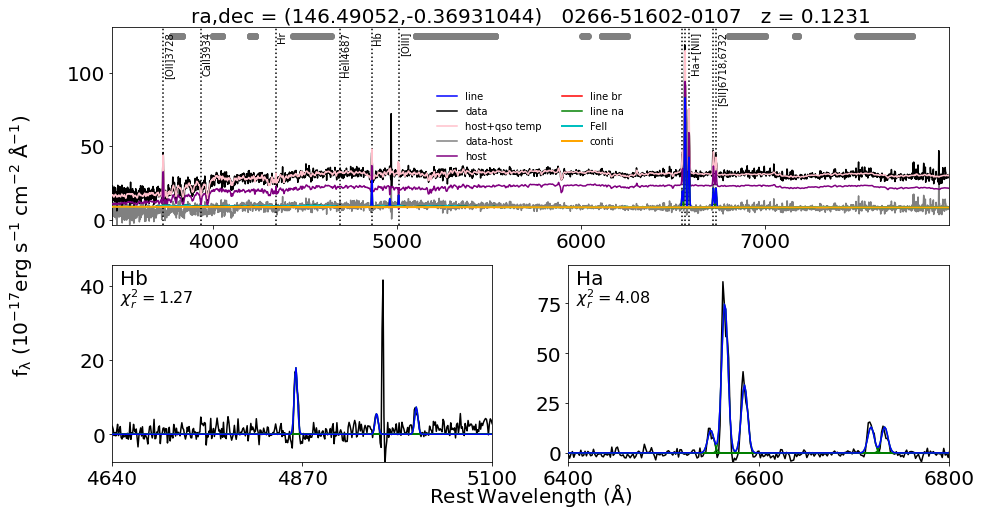

In [8]:
data = fits.open(path1+'example/data/spec-0266-51602-0107.fits')
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1./np.sqrt(data[1].data['ivar'])  # 1 sigma error
z = data[2].data['z'][0]                # Redshift


#Optinal
ra=data[0].header['plug_ra']          # RA 
dec=data[0].header['plug_dec']        # DEC
plateid = data[0].header['plateid']   # SDSS plate ID
mjd = data[0].header['mjd']           # SDSS MJD
fiberid = data[0].header['fiberid']   # SDSS fiber ID

    

q = QSOFit(lam, flux, err, z, ra = ra, dec = dec, plateid = plateid, mjd = mjd, fiberid = fiberid, path = path1)

q.Fit(name=None, nsmooth =1, and_or_mask = False, deredden = True, reject_badpix = False,wave_range = None,\
      wave_mask = None, decomposition_host = True, Mi = None, npca_gal = 5, npca_qso = 20,\
      Fe_uv_op = True, poly = False, BC = False, rej_abs = False, initial_guess = None, MC = True, \
      n_trails = 1, linefit = True, tie_lambda = True, tie_width = True, tie_flux_1 = True, tie_flux_2 = True,\
      save_result = True, plot_fig = True, save_fig = False, plot_line_name = True, plot_legend = True, \
      dustmap_path = path4, save_fig_path = path3, save_fits_path = path2, save_fits_name = None)

### 3. Fit normal galaxy
From the fitting, we can get the host galaxy compoent, then we can use [pPXF](http://www-astro.physics.ox.ac.uk/~mxc/software/) to get the velocity dispersion and starformation history.

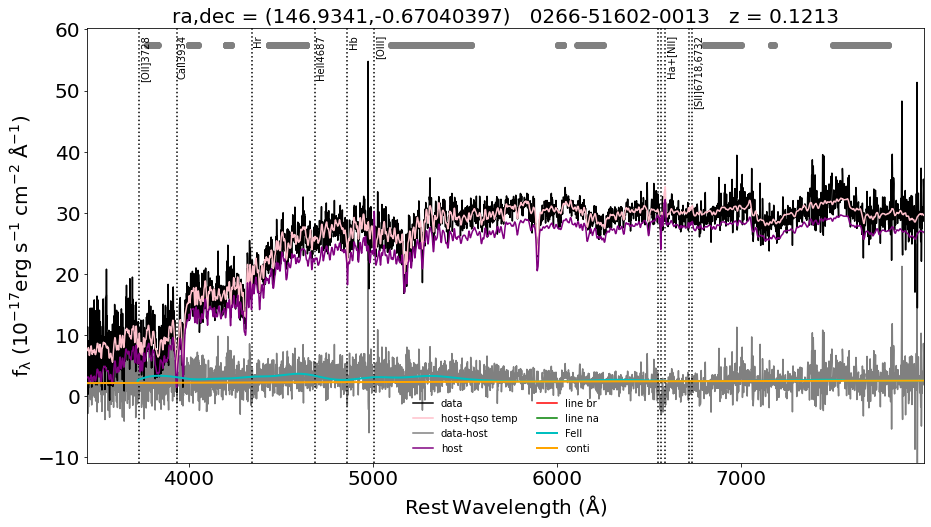

In [9]:
data = fits.open(path1+'example/data/spec-0266-51602-0013.fits')
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1./np.sqrt(data[1].data['ivar'])  # 1 sigma error
z = data[2].data['z'][0]                # Redshift


#Optinal
ra = data[0].header['plug_ra']          # RA 
dec = data[0].header['plug_dec']        # DEC
plateid = data[0].header['plateid']     # SDSS plate ID
mjd = data[0].header['mjd']             # SDSS MJD
fiberid = data[0].header['fiberid']     # SDSS fiber ID


q = QSOFit(lam, flux, err, z, ra = ra, dec = dec, plateid = plateid, mjd = mjd, fiberid = fiberid, path = path1)

q.Fit(name=None, nsmooth =1, and_or_mask = False, deredden = True, reject_badpix = False, wave_range =None,\
      wave_mask =None, decomposition_host = True, Mi = None, npca_gal = 5, npca_qso = 20,\
      Fe_uv_op = True, poly = False, BC = False, rej_abs = False, initial_guess = None, MC = True, \
      n_trails = 1,linefit = False, tie_lambda = True, tie_width = True, tie_flux_1 = True, tie_flux_2 = True,\
      save_result = True, plot_fig = True, save_fig = False,plot_line_name = True, plot_legend = True, \
      dustmap_path = path4, save_fig_path = path3, save_fits_path = path2, save_fits_name = None)